In [ ]:
from google.colab import drive
drive.mount("/content/drive")
path = "/content/drive/MyDrive/Enterprise Data Science and Machine Learning/zomato1.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install causalml  &> /dev/null

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from causalml.propensity import ElasticNetPropensityModel
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(path,encoding="latin-1")

In [ ]:
df=df[[ 'City','Average Cost for two', 'Has Table booking',
       'Has Online delivery', 'Is delivering now',
       'Price range', 'Votes','Aggregate rating']]

In [ ]:
df.head(100)

,City,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Votes,Aggregate rating
0,Agra,850,No,No,No,3,140,3.9
1,Agra,700,No,No,No,2,71,3.5
2,Agra,500,No,No,No,2,94,3.6
3,Agra,400,No,No,No,2,87,4.0
4,Agra,1000,No,No,No,3,177,4.2
...,...,...,...,...,...,...,...,...
95,Aurangabad,450,No,No,No,2,34,3.4
96,Aurangabad,450,No,No,No,2,89,3.7
97,Aurangabad,400,No,No,No,2,8,3.2
98,Aurangabad,650,No,No,No,2,39,3.4


In [ ]:
print(df['City'].value_counts())


New Delhi       5473
Gurgaon         1118
Noida           1080
Faridabad        251
Ghaziabad         25
Ahmedabad         21
Guwahati          21
Lucknow           21
Bhubaneshwar      21
Amritsar          21
Pune              20
Puducherry        20
Patna             20
Ludhiana          20
Ranchi            20
Surat             20
Vadodara          20
Nashik            20
Nagpur            20
Mysore            20
Mumbai            20
Varanasi          20
Mangalore         20
Agra              20
Kochi             20
Kolkata           20
Dehradun          20
Allahabad         20
Aurangabad        20
Bangalore         20
Bhopal            20
Chennai           20
Coimbatore        20
Goa               20
Indore            20
Jaipur            20
Kanpur            20
Vizag             20
Chandigarh        18
Hyderabad         18
Secunderabad       2
Panchkula          1
Mohali             1
Name: City, dtype: int64


Since there are way too many categories in the Cities column, we'll bucket the cities into region

In [ ]:
north_india = ['Ghaziabad', 'Lucknow', 'Amritsar', 'Ludhiana', 'Agra', 'Dehradun', 'Allahabad','Ahmedabad', 'Chandigarh','Kanpur','Mohali']
south_india = ['Puducherry', 'Kochi', 'Mangalore', 'Chennai', 'Coimbatore','Hyderabad', 'Secunderabad', 'Panchkula','Mysore','Bangalore','Vizag']
west_india = ['Pune', 'Surat', 'Vadodara', 'Mumbai', 'Goa','Nashik','Aurangabad']
central_india = ['Lucknow', 'Bhopal', 'Indore', 'Jaipur', 'Nagpur', 'Bhopal']
east_india = ['Bhubaneshwar', 'Guwahati', 'Ranchi', 'Kolkata', 'Varanasi','Patna']
df['Region'] = df['City']
df.loc[df['City'].isin(north_india), 'Region'] = 'North India'
df.loc[df['City'].isin(south_india), 'Region'] = 'South India'
df.loc[df['City'].isin(west_india), 'Region'] = 'West India'
df.loc[df['City'].isin(east_india), 'Region'] = 'East India'
df.loc[df['City'].isin(central_india), 'Region'] = 'Central India'

In [ ]:
print(df['Region'].value_counts())


New Delhi        5473
Gurgaon          1118
Noida            1080
Faridabad         251
North India       186
South India       181
West India        140
East India        122
Central India     101
Name: Region, dtype: int64


In [ ]:
df.fillna(df.mean(), inplace=True)
df.fillna(0, inplace=True)

In [ ]:
df['Has Table booking'] = df['Has Table booking'].map({'Yes': 1, 'No': 0})
df['Is delivering now'] = df['Is delivering now'].map({'Yes': 1, 'No': 0})
df['Has Online delivery'] = df['Has Online delivery'].map({'Yes': 1, 'No': 0})

In [ ]:
df=df[[ 'Region','Average Cost for two', 'Has Table booking',
       'Has Online delivery', 'Is delivering now',
       'Price range', 'Votes','Aggregate rating']]

In [ ]:
df

,Region,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Votes,Aggregate rating
0,North India,850,No,No,No,3,140,3.9
1,North India,700,No,No,No,2,71,3.5
2,North India,500,No,No,No,2,94,3.6
3,North India,400,No,No,No,2,87,4.0
4,North India,1000,No,No,No,3,177,4.2
...,...,...,...,...,...,...,...,...
8647,South India,600,No,No,No,2,193,3.6
8648,South India,400,No,No,No,2,85,3.7
8649,South India,600,No,No,No,2,172,4.3
8650,South India,1500,No,No,No,4,74,3.8


In [ ]:
df['Region'].value_counts()

New Delhi        5473
Gurgaon          1118
Noida            1080
Faridabad         251
North India       186
South India       181
West India        140
East India        122
Central India     101
Name: Region, dtype: int64

In [ ]:
df = pd.get_dummies(df, columns=['Region'], prefix='Region')
df

,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Votes,Aggregate rating,Region_Central India,Region_East India,Region_Faridabad,Region_Gurgaon,Region_New Delhi,Region_Noida,Region_North India,Region_South India,Region_West India
0,850,0,0,0,3,140,3.9,0,0,0,0,0,0,1,0,0
1,700,0,0,0,2,71,3.5,0,0,0,0,0,0,1,0,0
2,500,0,0,0,2,94,3.6,0,0,0,0,0,0,1,0,0
3,400,0,0,0,2,87,4.0,0,0,0,0,0,0,1,0,0
4,1000,0,0,0,3,177,4.2,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8647,600,0,0,0,2,193,3.6,0,0,0,0,0,0,0,1,0
8648,400,0,0,0,2,85,3.7,0,0,0,0,0,0,0,1,0
8649,600,0,0,0,2,172,4.3,0,0,0,0,0,0,0,1,0
8650,1500,0,0,0,4,74,3.8,0,0,0,0,0,0,0,1,0


(array([7541.,    0., 1111.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

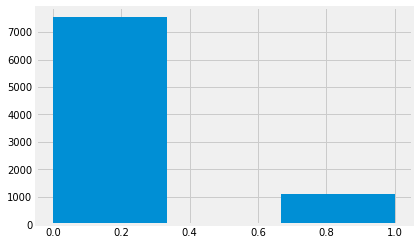

In [ ]:
plt.hist(df['Has Table booking'], bins=3)

## Let's take Online Delivery as treatment column

In [ ]:
df1=df
df = df.rename(columns={'Has Table booking': 'treatment'})

In [ ]:
df.columns

Index(['Average Cost for two', 'treatment', 'Has Online delivery',
       'Is delivering now', 'Price range', 'Votes', 'Aggregate rating',
       'Region_Central India', 'Region_East India', 'Region_Faridabad',
       'Region_Gurgaon', 'Region_New Delhi', 'Region_Noida',
       'Region_North India', 'Region_South India', 'Region_West India'],
      dtype='object')

In [ ]:
features = df.loc[:, ['Average Cost for two','Has Online delivery',
       'Is delivering now', 'Price range', 'Votes',
       'Region_East India', 'Region_Faridabad', 'Region_Gurgaon',
       'Region_New Delhi', 'Region_Noida', 'Region_North India',
       'Region_South India', 'Region_West India','treatment']]
treatment = df.loc[:,['treatment']]
y = df.loc[:, ['Aggregate rating']]

##Balancing the imbalanced Dataset

In [ ]:
df_majority = df[df['Has Online delivery'] == 0]
len(df_majority)

6229

In [ ]:
df_minority = df[df['Has Online delivery'] == 1]
len(df_minority)

2423

In [ ]:
df1=df
df = df[['treatment', 'Has Online delivery',
       'Is delivering now', 'Price range', 'Votes', 'Aggregate rating',
       'Region_East India', 'Region_Faridabad',
       'Region_Gurgaon', 'Region_New Delhi', 'Region_Noida',
       'Region_North India', 'Region_South India', 'Region_West India'
       ]]
df_balanced=df

######The Dataset seems to be very unbalanced when it comes to  'Has Online delivery'==1 , hence we take a sample of  the dataset

In [ ]:
df_majority = df[df['Has Online delivery'] == 0]
df_minority = df[df['Has Online delivery'] == 1]
df_majority_sampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_sampled, df_minority])

In [ ]:
# Lets assign X (Control Feature), y (Target) and treatment

#Control Feature
X = df_balanced.loc[:,df_balanced.columns != 'treatment']
#X = X.loc[:, X.columns != 'Average Cost for two']
X = X.loc[:, X.columns != 'Aggregate rating']

feature_names = X.columns

# Treatment
treatment = df_balanced['treatment']
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in treatment])

# Target
y = df_balanced['Aggregate rating']

##Calculate Average Treatment Effect (ATE)

In [ ]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.08904877]), array([0.00175683]), array([0.17634071]))
ATE estimate: 0.089
ATE lower bound: 0.002
ATE upper bound: 0.176
(array([0.08904877]), array([0.00175683]), array([0.17634071]))
ATE estimate: 0.089
ATE lower bound: 0.002
ATE upper bound: 0.176


**Interpretation** 
ATE estimate: This value represents the estimated average treatment effect of having online delivery. In this case, the estimate is 0.089, which means that, on average, having online delivery option  may result in an increase of 0.089 rating of the restaurant.
The lowest increase in rating could be 0.002 and the highest increase in rating could be as high as 0.176.

Thus,it can be concluded that having an online delivery will have a positive effect on the rating of the restaurant.

Since the predication variable's range is 1-5, having an ATE of 0.089 means that the treatment variable does have an impact on the final outcome.

In [ ]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor(objective='reg:squarederror')
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)


Using the ready-to-use XGBTRegressor class
(array([-0.00778567]), array([-0.03741169]), array([0.02184035]))
[02:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Using the BaseTRegressor class and using XGB (same result):
(array([-0.00778567]), array([-0.03741169]), array([0.02184035]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.34482912]), array([0.28150135]), array([0.40815689]))


In [ ]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [ ]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=p)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=p)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

[01:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB:
(array([-0.02121061]), array([-0.05077813]), array([0.00835692]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.3494964]), array([0.28622711]), array([0.41276569]))


In [ ]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

[01:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB without propensity score input:
(array([-0.03294186]), array([-0.06257993]), array([-0.00330379]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.35085575]), array([0.28759581]), array([0.4141157]))


In [ ]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=p)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=p)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

[01:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB:
(array([-0.01390058]), array([-0.01437598]), array([-0.01342519]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.03677501]), array([0.03579433]), array([0.0377557]))


In [ ]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

[01:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB without propensity score input:
(array([-0.03294186]), array([-0.06257993]), array([-0.00330379]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.35085575]), array([0.28759581]), array([0.4141157]))


In [ ]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=p)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=p)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

[01:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB:
(array([-0.01389094]), array([-0.01436665]), array([-0.01341523]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.03618359]), array([0.03519836]), array([0.03716882]))


In [ ]:
# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
sample_weight = np.random.randint(1, 3, len(y))
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=p, sample_weight=sample_weight)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

[01:43:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB:
(array([-0.00593758]), array([-0.0064094]), array([-0.00546577]))


In [ ]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

[01:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB without propensity score input:
(array([-0.00723706]), array([-0.00771415]), array([-0.00675997]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([-0.70866908]), array([-0.70965819]), array([-0.70767996]))


##Calculate Individual Treatment Effect (ITE/CATE)

In [ ]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=p)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=p)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

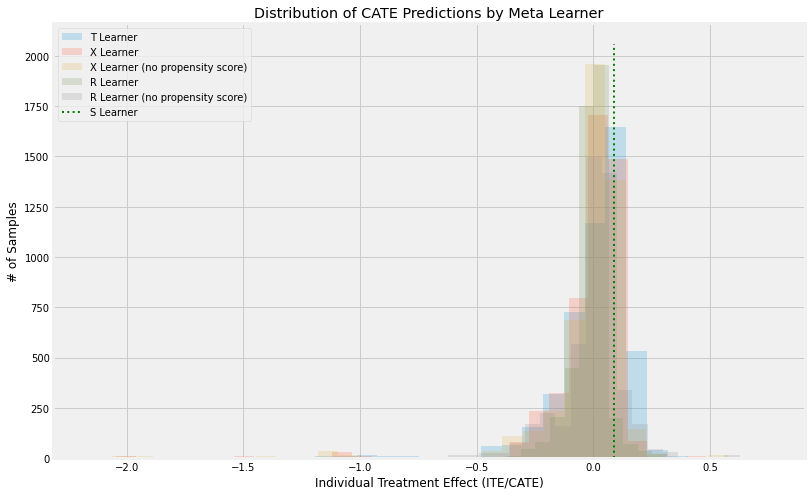

In [ ]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

##Validating Meta-Learner Accuracy

In [ ]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [ ]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.364849,0.075689,3.768866
S Learner (XGB),0.137865,0.024194,0.168971
T Learner (LR),0.343812,0.034164,0.306624
T Learner (XGB),0.143536,0.071644,0.276783
X Learner (LR),0.343812,0.034164,0.306624
X Learner (XGB),0.081427,0.031538,0.081192
R Learner (LR),0.283943,0.032078,0.283568
R Learner (XGB),0.061028,0.059370,0.077027


In [ ]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.370255,0.076133,3.694066
S Learner (XGB),0.138028,0.024465,0.208274
T Learner (LR),0.344152,0.033951,0.337752
T Learner (XGB),0.145148,0.066319,0.284081
X Learner (LR),0.344152,0.033951,0.337752
X Learner (XGB),0.081653,0.029286,0.098889
R Learner (LR),0.283040,0.031659,0.305638
R Learner (XGB),0.062067,0.054199,0.088470


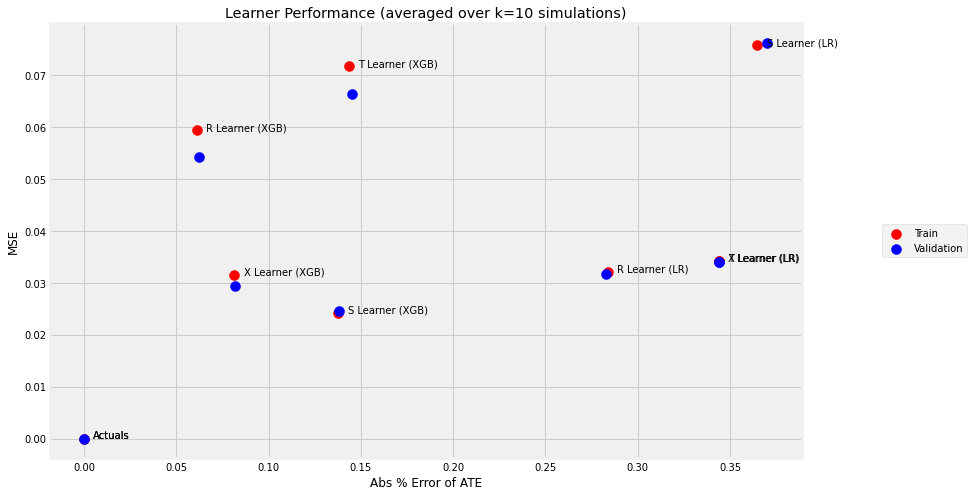

In [ ]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

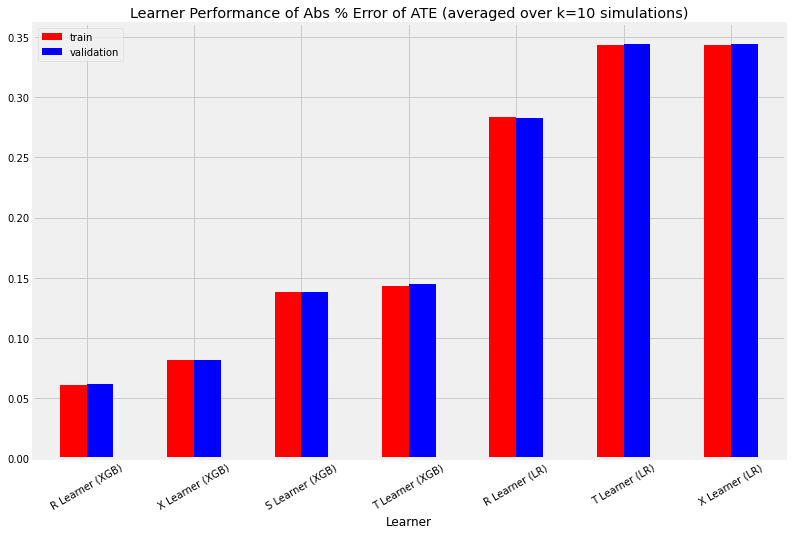

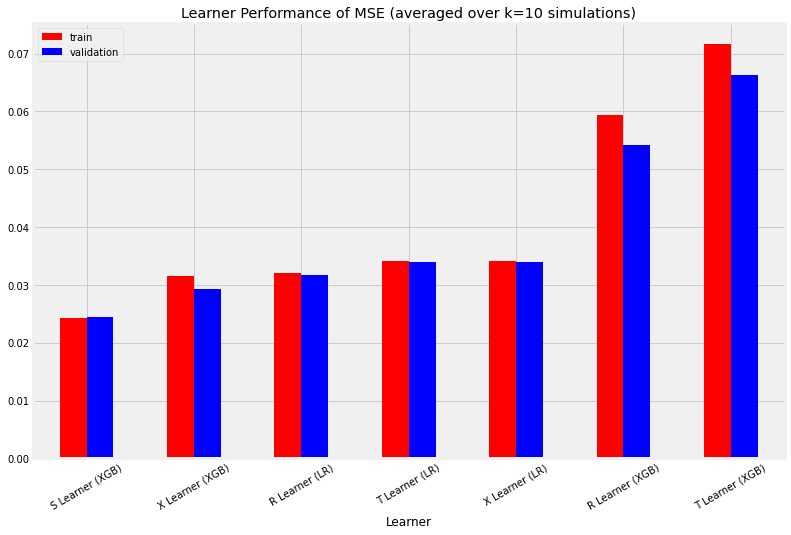

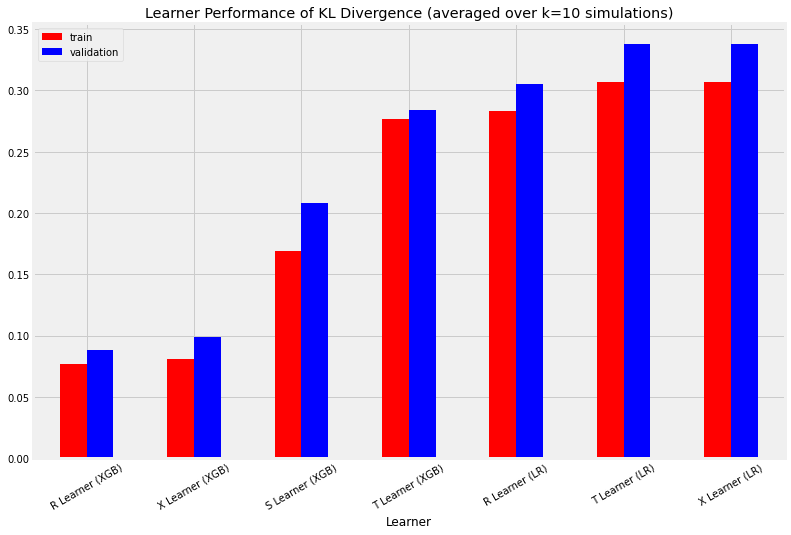

In [ ]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [ ]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

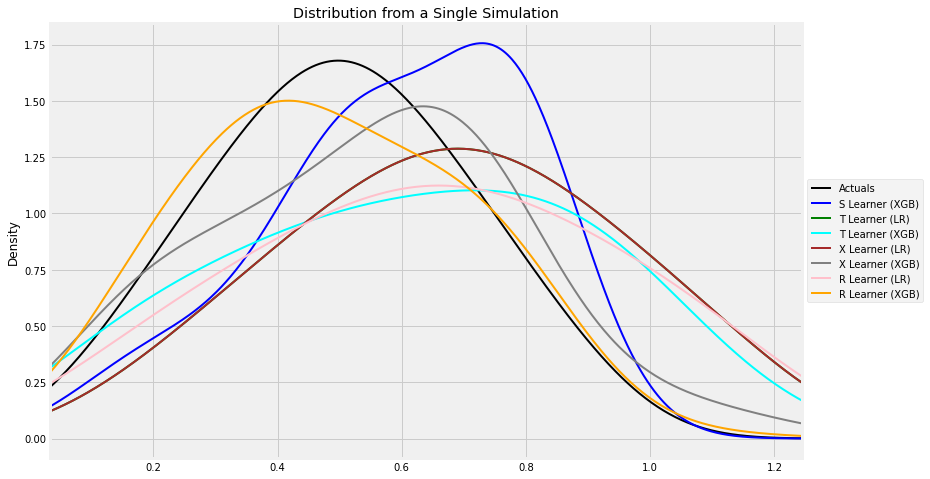

In [ ]:
#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

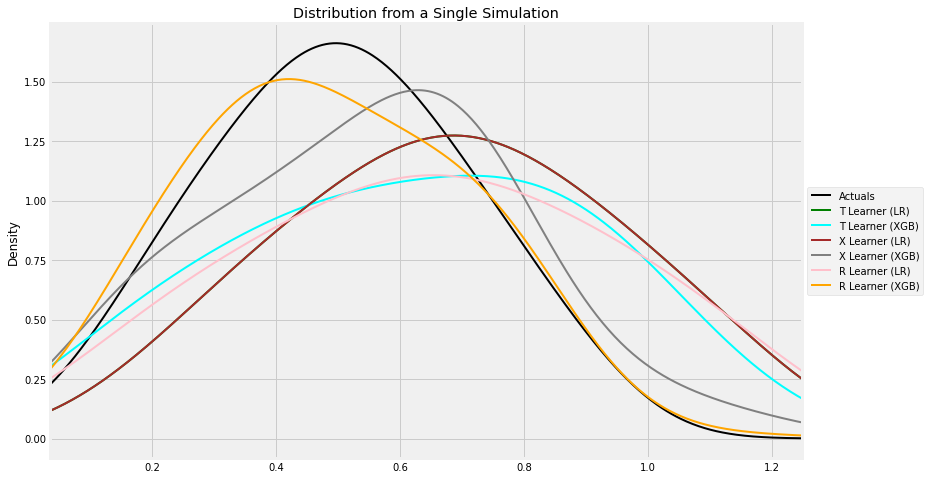

In [ ]:
#distribution plot for single simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

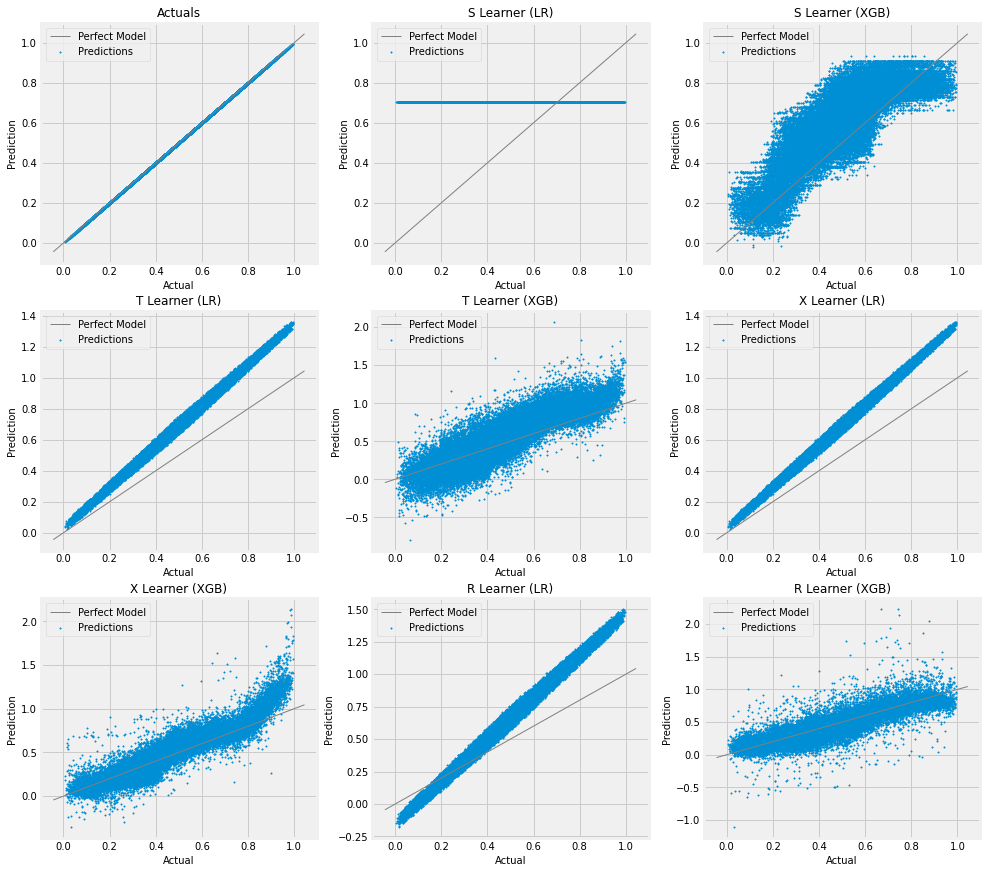

In [ ]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

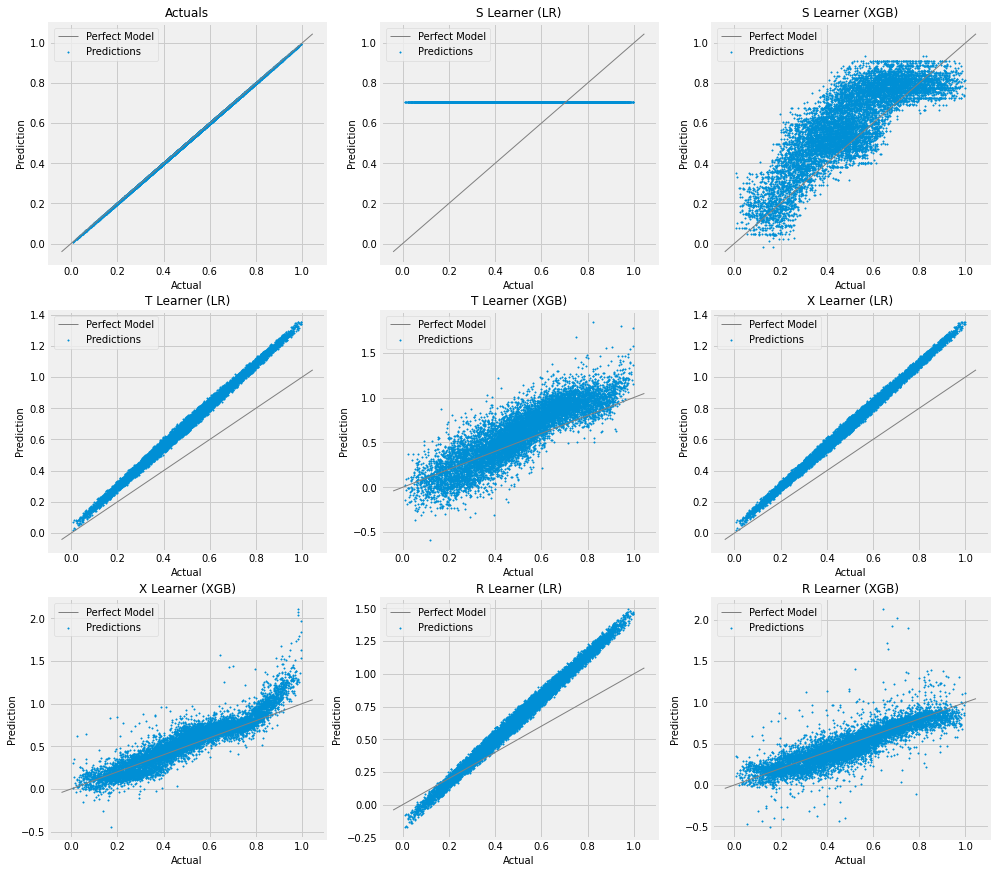

In [ ]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

,Learner,cum_gain_auuc
0,Actuals,4.930151e+06
2,T Learner (LR),4.927688e+06
4,X Learner (LR),4.927688e+06
6,R Learner (LR),4.925688e+06
5,X Learner (XGB),4.875228e+06
7,R Learner (XGB),4.833792e+06
3,T Learner (XGB),4.827895e+06
1,S Learner (XGB),4.783781e+06
8,Random,3.997011e+06


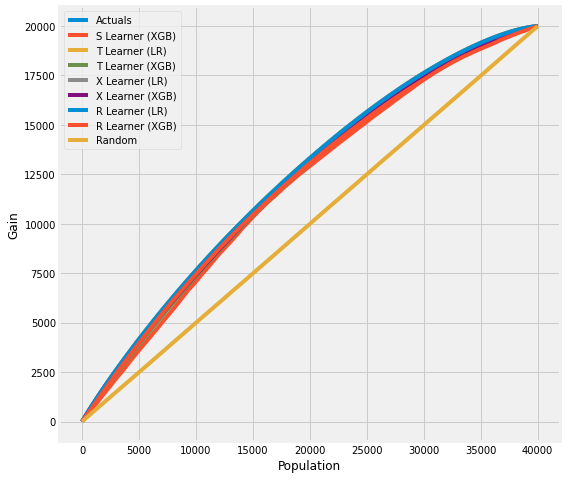

In [ ]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,309007.371978
2,T Learner (LR),308853.721378
4,X Learner (LR),308853.721378
6,R Learner (LR),308727.209671
5,X Learner (XGB),305545.570330
7,R Learner (XGB),303040.803207
3,T Learner (XGB),302424.742653
1,S Learner (XGB),299711.856338
8,Random,250407.379876


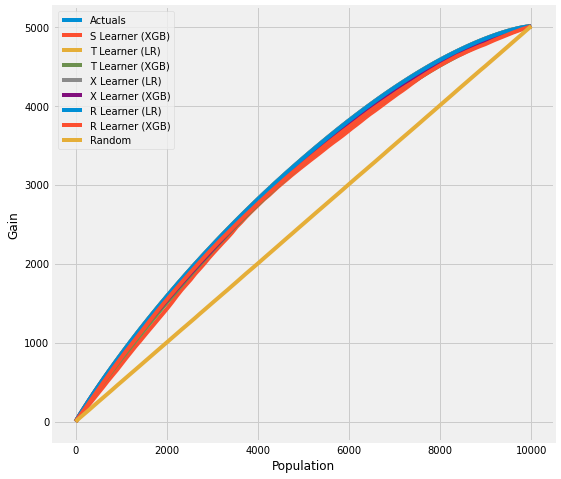

In [ ]:
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])

##Finding the feature importance of each model

In [ ]:
model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

In [ ]:
base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.08904877])

In [ ]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

In [ ]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': Votes                  0.777778
 Price range            0.222222
 Has Online delivery    0.000000
 Is delivering now      0.000000
 Region_East India      0.000000
 Region_Faridabad       0.000000
 Region_Gurgaon         0.000000
 Region_New Delhi       0.000000
 Region_Noida           0.000000
 Region_North India     0.000000
 Region_South India     0.000000
 Region_West India      0.000000
 dtype: float64}

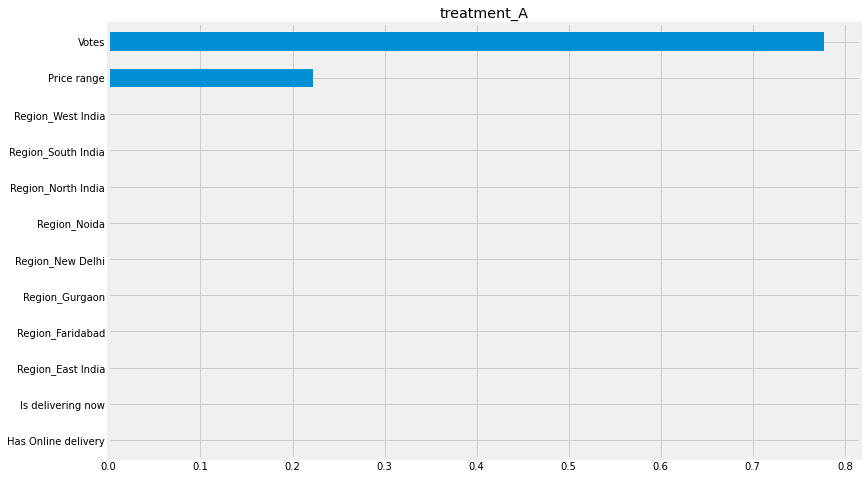

In [ ]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

**Insights**<br>
 Votes and the price range of the restraunt are the important variables

**Interpretation** <br>The feature importance values reflect the significance of each feature in determining the prediction output of the model, with regards to its effect on the treatment outcome. The greater the importance value, the more impactful the feature is in determining the treatment outcome.

For instance, if a feature has a high importance value, it implies that variations in that feature will have a significant impact on the treatment outcome. Conversely, if a feature has a low importance value, it indicates that it has a limited effect on the treatment outcome and changes in that feature will have a negligible impact.

#### Permutation

In [ ]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': Has Online delivery     0.0
 Is delivering now       0.0
 Price range             0.0
 Votes                   0.0
 Region_Central India    0.0
 Region_East India       0.0
 Region_Faridabad        0.0
 Region_Gurgaon          0.0
 Region_New Delhi        0.0
 Region_Noida            0.0
 Region_North India      0.0
 Region_South India      0.0
 Region_West India       0.0
 dtype: float64}

In [ ]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.0876767635345459 seconds


Most of the feature importance variables turned out to be 0.

## Shapley Values - XGBOOST


In [ ]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.00000000e+00, 0.00000000e+00, 1.34641533e-19, 3.84594209e-19,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [ ]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.00000000e+00, 0.00000000e+00, 1.34641533e-19, 3.84594209e-19,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

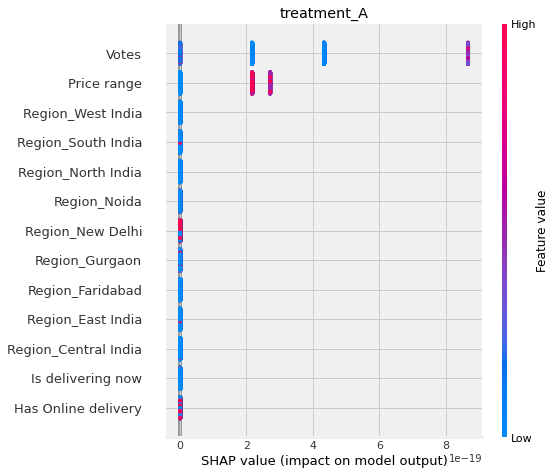

In [ ]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

Votes have a low effect on the feature value; and Price range has a comparitively higher effect on the feature value.

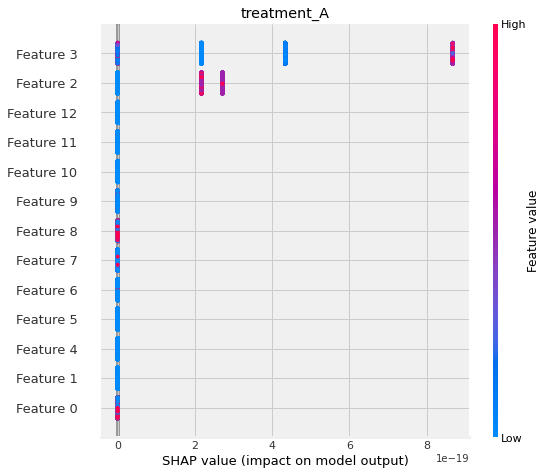

In [ ]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

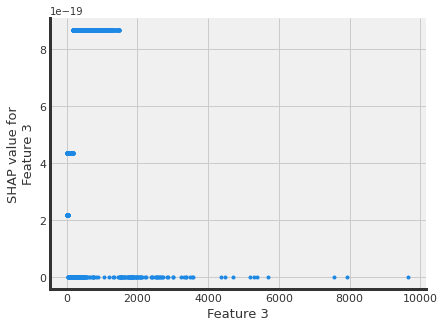

In [ ]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

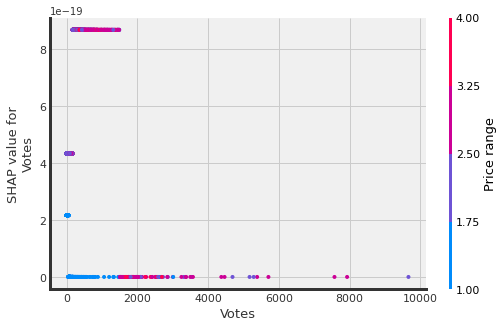

In [ ]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

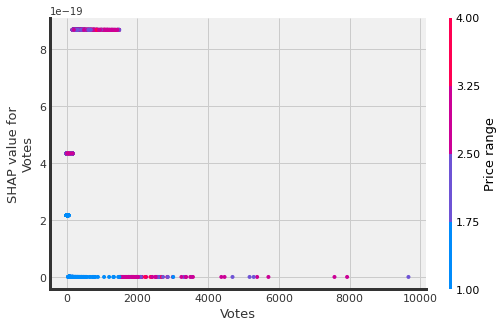

In [ ]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

##T Learner - XGB

In [ ]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)


(array([-0.02007902]), array([-0.05425285]), array([0.01409481]))

In [ ]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

## Feature Importances (method = auto)


In [ ]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': Votes                  0.941013
 Region_New Delhi       0.022308
 Price range            0.012603
 Has Online delivery    0.010227
 Region_Gurgaon         0.005680
 Region_Noida           0.002941
 Region_North India     0.002099
 Region_South India     0.001383
 Region_West India      0.001008
 Region_Faridabad       0.000501
 Is delivering now      0.000175
 Region_East India      0.000065
 dtype: float64}

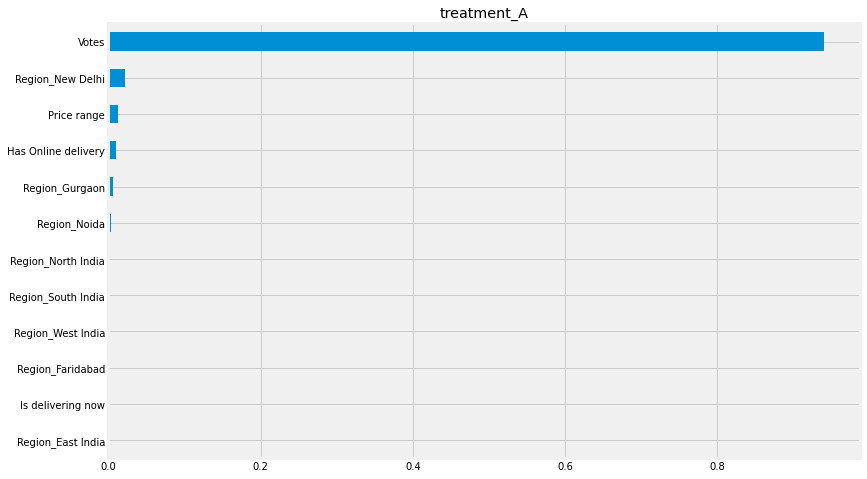

In [ ]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

Using t learner , we get an insight on how the votes, new Delhi region, Price range, Online Delivery etc  are comparitively more important compared to previous learner

In [ ]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': Votes                  1.909435
 Region_New Delhi       0.095011
 Price range            0.038045
 Region_Gurgaon         0.034546
 Has Online delivery    0.023366
 Region_Noida           0.017495
 Region_South India     0.003406
 Region_Faridabad       0.002198
 Region_North India     0.002033
 Region_West India      0.000345
 Is delivering now      0.000143
 Region_East India      0.000089
 dtype: float64}

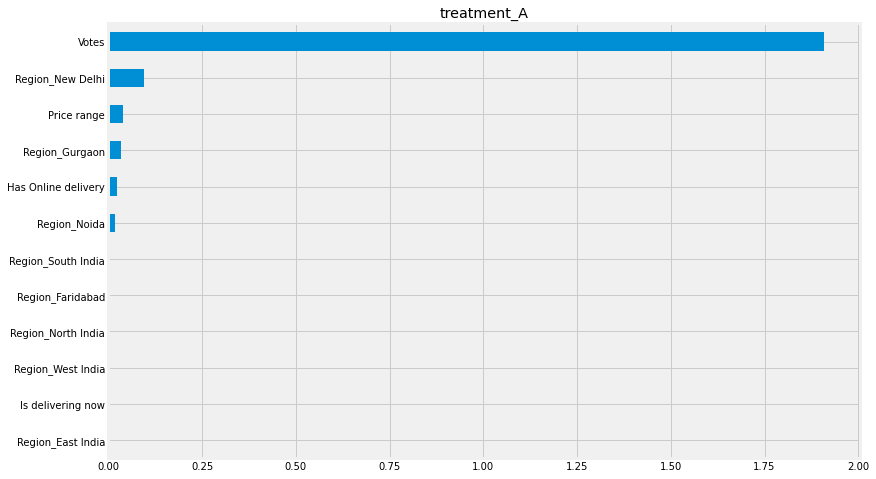

In [ ]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

##Feature Importance (sklearn.inspection.permutation_importance)

In [ ]:
X = X.values

In [ ]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)
perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)


Votes                  1.909435
Region_New Delhi       0.095011
Price range            0.038045
Region_Gurgaon         0.034546
Has Online delivery    0.023366
Region_Noida           0.017495
Region_South India     0.003406
Region_Faridabad       0.002198
Region_North India     0.002033
Region_West India      0.000345
Is delivering now      0.000143
Region_East India      0.000089
dtype: float64

In [ ]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Votes                  1.909435
Region_New Delhi       0.095011
Price range            0.038045
Region_Gurgaon         0.034546
Has Online delivery    0.023366
Region_Noida           0.017495
Region_South India     0.003406
Region_Faridabad       0.002198
Region_North India     0.002033
Region_West India      0.000345
Is delivering now      0.000143
Region_East India      0.000089
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

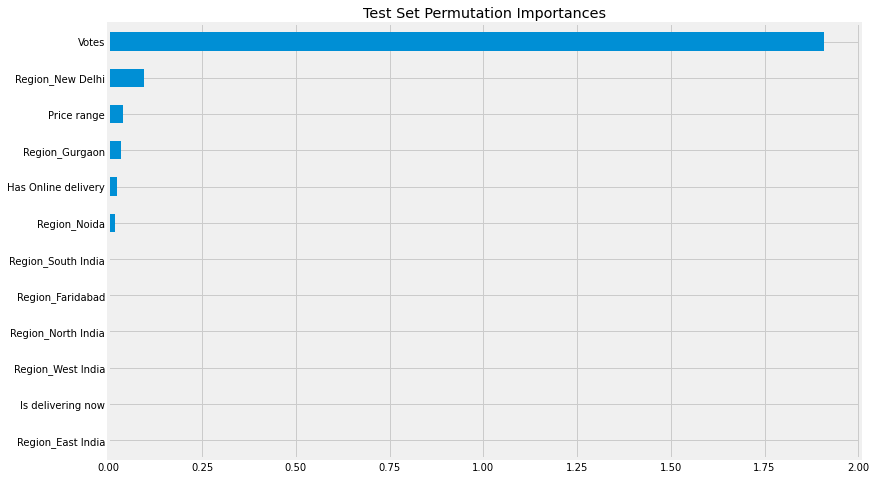

In [ ]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [ ]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[ 0.00369951, -0.00020366, -0.01236029, ...,  0.00104826,
         -0.00013264,  0.00022387],
        [ 0.00369951, -0.00020366, -0.01236029, ...,  0.00104826,
         -0.00013264,  0.00022387],
        [ 0.00369951, -0.00020366, -0.01236029, ...,  0.00104826,
         -0.00013264,  0.00022387],
        ...,
        [ 0.0143994 , -0.00051543,  0.03948845, ...,  0.00041363,
         -0.01378154, -0.05538821],
        [ 0.01499864, -0.00062041, -0.06957492, ...,  0.0002586 ,
         -0.01466755, -0.0317662 ],
        [-0.00982429, -0.0004119 ,  0.02859014, ...,  0.00259386,
          0.01311546,  0.00395516]])}

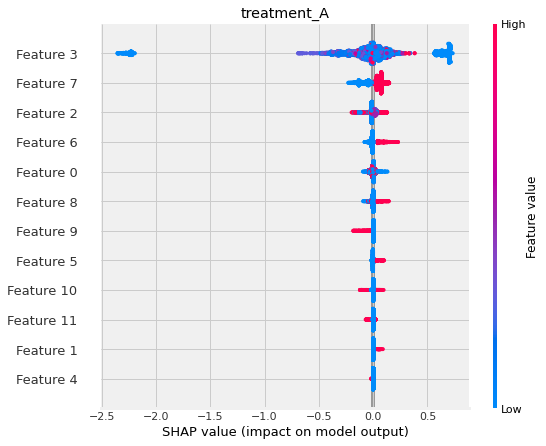

In [ ]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(X=X, shap_dict=shap_tlearner)

 Lower value of Feature 3 ,ie, Votes can have impact on the final results. Higher values on the other  hand may not necessarily have a positive impact.
 For feature 7 , high value will have positive impact and low vaule will have negative impact..
 Similarly for feature 6, high value will have more positive mpact compared to low values which will have slightly lesser neative impact.
 For feature 9, high value will have negative impact.




## X Learner

In [ ]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [ ]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y, p=p)

(array([-0.0258151]), array([-0.05742954]), array([0.00579934]))

In [ ]:
xlearner_tau = xlearner.predict(X, w_multi, y, p=p)

In [ ]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': Votes                   1.903513
 Region_New Delhi        0.080502
 Price range             0.073872
 Has Online delivery     0.060177
 Region_Gurgaon          0.024747
 Region_Central India    0.008010
 Region_North India      0.007368
 Region_Noida            0.004243
 Region_West India       0.002187
 Region_South India      0.001946
 Region_East India       0.000342
 Is delivering now       0.000096
 Region_Faridabad        0.000047
 dtype: float64}

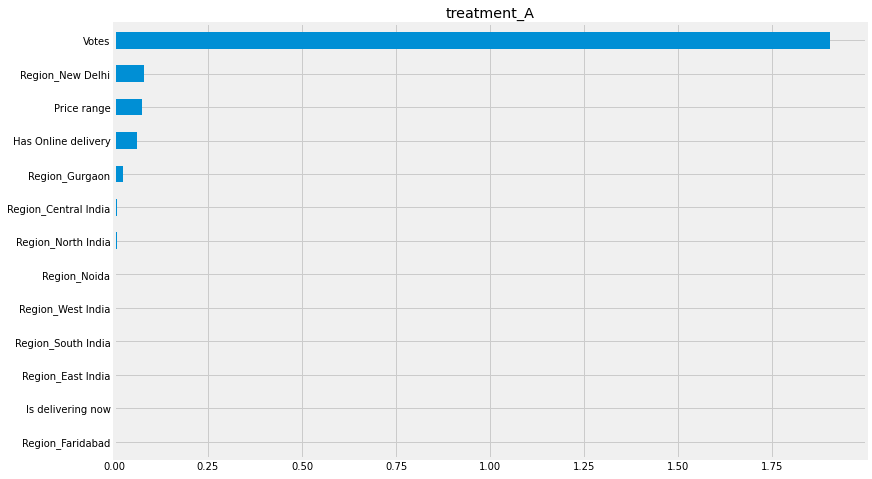

In [ ]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

##Feature Importance (sklearn.inspection.permutation_importance)

In [ ]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.6543819904327393 seconds


In [ ]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Votes                   1.903513
Region_New Delhi        0.080502
Price range             0.073872
Has Online delivery     0.060177
Region_Gurgaon          0.024747
Region_Central India    0.008010
Region_North India      0.007368
Region_Noida            0.004243
Region_West India       0.002187
Region_South India      0.001946
Region_East India       0.000342
Is delivering now       0.000096
Region_Faridabad        0.000047
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

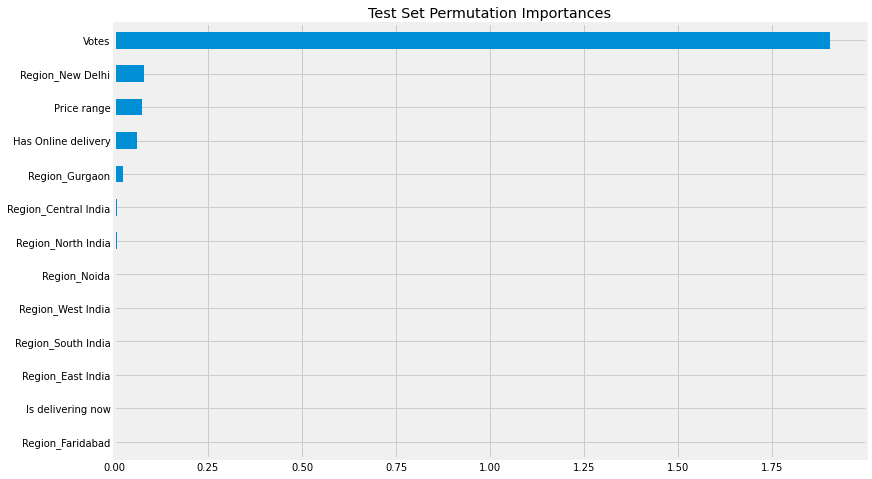

In [ ]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

**Insight**


Votes, Presence of the restraunt in New Delhi region,Price Range, Online Delivery, Presence of the restaurant in Gurgaon are some of the important varibles for thre prediction.

## Shapley Values

Shapley value is the average amount of contribution that a member makes to the contribution.

In [ ]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[-0.00413711, -0.00014835, -0.00574879, ...,  0.00176055,
          0.00034731,  0.00059014],
        [-0.00413711, -0.00014835, -0.00574879, ...,  0.00176055,
          0.00034731,  0.00059014],
        [-0.00413711, -0.00014835, -0.00574879, ...,  0.00176055,
          0.00034731,  0.00059014],
        ...,
        [ 0.03231759, -0.00023911,  0.02029579, ...,  0.00358205,
         -0.00218919, -0.09666529],
        [ 0.02297303, -0.00034357, -0.05941695, ...,  0.0018002 ,
         -0.00553585, -0.05740374],
        [ 0.01782103, -0.00017619,  0.02200028, ...,  0.00426963,
         -0.02156887,  0.00510756]])}

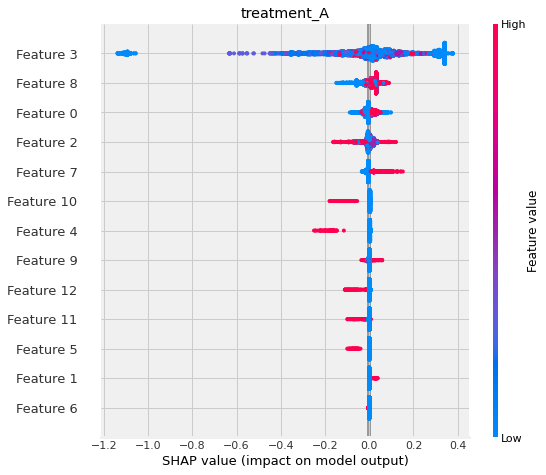

In [ ]:
# shap_dict specified
xlearner.plot_shap_values(X=X, shap_dict=shap_xlearner)

The SHAP values indicate the extent to which each feature influences the prediction, either positively or negatively.

Each point on the plot corresponds to a single observation. The SHAP values are displayed along the horizontal axis, while the color of the point indicates whether the value of that particular observation is higher or lower in comparison to other observations. Points colored red indicate a high value, while those colored blue indicate a low value.

For feature 3, ie votes, lower values will have more negative impact compared to higher values.
For feature 7  high values will have more positive effect compared to low values having negative effect.

##R Learner

In [ ]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, w_multi, y, p=p)

In [ ]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': Votes                   1.105878
 Price range             0.363289
 Region_New Delhi        0.134417
 Has Online delivery     0.090536
 Region_Gurgaon          0.067399
 Region_Noida            0.061079
 Region_North India      0.046872
 Region_West India       0.014768
 Region_Central India    0.002215
 Region_East India       0.000566
 Is delivering now       0.000194
 Region_Faridabad        0.000000
 Region_South India     -0.001739
 dtype: float64}

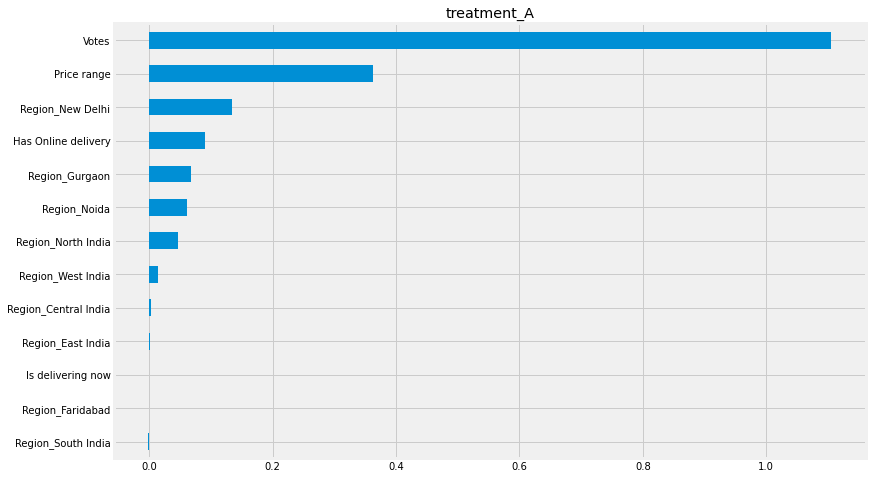

In [ ]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

**Conclusion** <br>
The models using various meta-learners (S Learner, T Learner, X Learner, and R Learner) all demonstrated a positive relationship between the treatment variable (Has Online Delivery) and the target variable (rating of the restaurant). This supports the idea that offering online delivery enhances the rating of the restaurant.

These meta-learners were employed to calculate the Individual Treatment Effect (ITE) of the treatment variable (Has Online Delivery) on the target variable (rating). The results of the analysis revealed that for most of the models used, the ITE predictions were positive.

By using different techniques to control for the potential confounding effects of other variables, the positive impact of the treatment variable on the target variable is strengthened. This positive impact is reinforced by the S Learner and T Learner methods, which provide a single ITE estimate, while the X Learner and R Learner methods present a distribution of ITE estimates.

The distribution of ITE estimates from the X Learner and R Learner methods also indicates a high level of certainty in the positive impact of the treatment variable on the target variable, as the majority of the samples exhibit positive ITE predictions, indicating consistent impact across different samples.

It is important to consider that the validity of these results is contingent upon the quality of the data and the appropriateness of the models used. However, the results offer strong support for the idea that offering online delivery positively impacts the rating of the restaurant and can provide valuable insights for future decision making in this area. Also, there is an assumption that there is no alternate causes that are affecting the  ratings of the restaurants.

Furthermore, the models also help us to indentify the other factors such as regions which can help in  having a higher rated restaurants. The  given work can be utilised by restaurant business to strategically make decisions that can help in boosting the rating of the restaurant.